# A Basic Model of Electricity and Heat Systems

In this exercise, we will be working with the a simplified version of the `mBasicPH` model adapted to the model setting above. As we will be using analytical results from Exercise 41-H, we strongly recommend that you cover the material in Exercise 41-H, before proceeding.

The file `HP_InputData.xlsx` includes a model database with parameters for the model. We refer to the scenario with parameters as outlined in this data as the _baseline_ scenario. The table below translates the names used in the data to the symbols used in the model. 

| Name in excel file | Model symbol |
|:--------|:--------:|
| id | $i$ | 
| BFt | $j$ |
| h | $h$ |
|  FuelMix   |  $\mu_{i,j}$   |
|  GeneratingCapacity   | $q_i$   |
|  OtherMC   | $c_i^{oth}$   |
| E2H | $\nu_i$ |
| FuelPrice | $p_j^f$ |
| EmissionIntensity | $\phi_j$ |
| MWP, E | $\mu_E$ |
| MWP, H | $\mu_E$ |
| LoadVariation, E | $L_h^E$ |
| LoadVariation, H | $L_h^H$ |
| CapVariation | $\gamma_{i,h} $ |

For working with the model, we first import some packages and the modelclass:

In [1]:
# from .py.modelclass import *
%run ../stdPackages.ipynb
from pyDbs import *
from IPython.display import Image
figs_path = os.path.join(d['curr'],'E41', 'Figs')
os.chdir(os.path.join(d['curr'], 'E41', 'py'))
from modelclass import *
os.chdir(d['curr'])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next we load the database:

In [2]:
kwargs = {'variables': ['Fundamentals', 'LoadVariables', 'GeneratorsVariables'],
        'maps': ['LoadMaps','GeneratorsMaps'],
        'variable2D': ['HourlyVariation'],
        'scalars': ['Scalars']}
path_to_data = os.path.join(d['curr'],'E41', 'Data', 'E41_Data.xlsx')
db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

We then initialize and solve the model:

In [3]:
m = mSimple(db.copy()) # initialize using the database 'db' from above.
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


Finally, we will store some variables for the different technology types:

In [4]:
# Get a mapping from id to modelTech:
id2modelTech = m.db['id2tech'].to_frame(index=False).merge(m.db['tech2modelTech'].to_frame(index=False)).set_index(['id','tech','modelTech'])
# Back-pressure plants:
BP_id = db['id'][db['id'].isin(id2modelTech.xs('BP',level='modelTech').index.get_level_values('id'))]
# Standard electricity plants:
StdE_id = db['id'][db['id'].isin(id2modelTech.xs('standard_E',level='modelTech').index.get_level_values('id'))]
# All electricity plants:
E_id = BP_id.append(StdE_id)
# Standard heat plants:
StdH_id = db['id'][db['id'].isin(id2modelTech.xs('standard_H',level='modelTech').index.get_level_values('id'))]
# Heat pumps
HP_id = db['id'][db['id'].isin(id2modelTech.xs('HP',level='modelTech').index.get_level_values('id'))]
# All heat plants
H_id = StdH_id.append(HP_id)

In the following, we will show how to  illustrate the hourly demand curve for heat. We will draw the curve $h=\{1,5\}$. You task in the following, will be to draw the supply curve for heat, as well as the supply and demand curve for electricity in the same hours.

We start by making a grid of $h=\{1,5\}$:

In [5]:
h_grid = [1,5]

We will also define a minimum price for drawing the curve:

In [6]:
loλ = 0

To make the illustration, we will first make a dateframe with quantity demand and the associated willingness to pay:

In [7]:
# First we create a multiindex for the dataframe
mi_Hd = pd.MultiIndex.from_product([['c1'],m.db['h']],names=['c_type','h'])

# Now we build a dataframe with the demanded quantity and the marginal willingess to pay.
df_Hd = pd.concat([
  pd.Series(m.hourlyLoad_H.tolist(),index=mi_Hd,name='H'), # Hourly demand
  pd.Series(list(np.repeat(m.db['MWP_H'],len(m.db['h']))),index=mi_Hd,name='mwp'), # MWP_H
],axis=1)

Because the demand is kinked at the willingess to pay, we need a data-point above and below to draw the curve.

The point above the kink is:

In [8]:
ϵ = np.finfo(float).eps*10**6 # small number
# Upper point (crossing with y-axes):
mi_Hd_up = pd.MultiIndex.from_product([['0'],db['h'].tolist()], names=['c_type','h'])
df_Hd_up = pd.concat([
    pd.Series(-ϵ,index=mi_Hd_up,name='H'),
    pd.Series(m.db['MWP_H']+ϵ,index=mi_Hd_up,name='mwp')
],axis=1)

The point below is

In [9]:
# Lower point (crossing with x-axis):
mi_Hd_lo = pd.MultiIndex.from_product([['-1'],db['h'].tolist()],names=['c_type','h'])
df_Hd_lo = pd.concat([
    pd.Series(ϵ,index=mi_Hd_lo,name='H'),
    pd.Series(loλ,index=mi_Hd_lo,name='mwp')
],axis=1)

Finally, we collect it all in a common dataframe and aggregate demand:

In [10]:
df_Hd = pd.concat([df_Hd,df_Hd_up,df_Hd_lo],axis=0).sort_values(['h','mwp'],ascending=[True,False])
df_Hd['H_cs'] =df_Hd.groupby('h')['H'].transform('cumsum')

Now we make the graph:

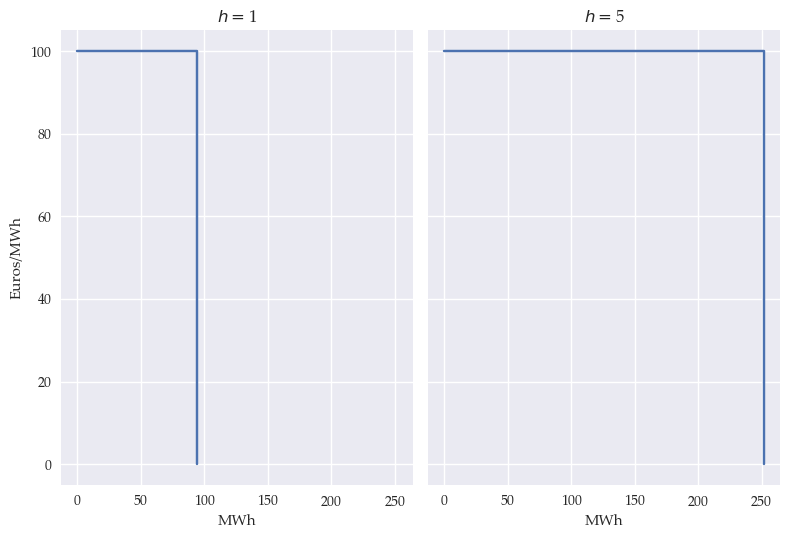

In [11]:
fig, ax = plt.subplots(ncols=2,sharex=True,sharey=True)
for i in range(len(h_grid)):
    h = h_grid[i]
    ax[i].step(df_Hd.xs(h,level='h')['H_cs'],df_Hd.xs(h,level='h')['mwp'])
    ax[i].set_title(r'$h=$'+str(h))
    
[ax[i].set_xlabel('MWh') for i in [0,1]];
ax[0].set_ylabel('Euros/MWh')
fig.tight_layout()

## E1

__Compute and illustrate the hourly supply curve (i.e. the merit order curve) for heat for hours $h=\{1,5\}$. Include also the demand curve and the optimal value ${\lambda^H_h}^*$ Finally, discuss how the reservation price of heat can be negative in $h=1$.__

*Note: To compute the supply curve, you have to realize the the reservation price for back-pressure plants and heat pumps is not equal to their marginal costs $(mc_i)$ because their reservation price depend on the electricity market. Therefore, you may draw the supply curve given the optimal value ${\lambda_{h}^{E}}^{*}$.*

*Furthermore, the graph should look something like this:*

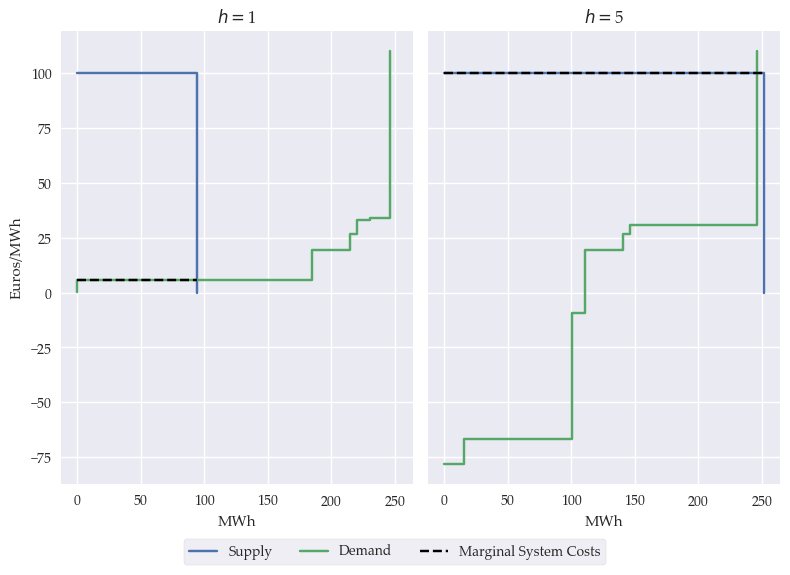

In [12]:
Image(os.path.join(figs_path,'E2.1_sol.png'))

## E2

__Illustrate the demand curve for electricity for $h=\{1,5\}$ and comment on why the maximum willingness to pay in $h=5$ is so high.__ 

_Note: For this, you have to illustrate the aggregate demand curve is composed of the sum of the set of conventional consumes $(c_E)$ as well that the sum of heat pumps' maximum capacity for electricity consumption: $-\sum_{i\in\mathcal{I}^E}\nu_iq_{i,h}$. Hence, you will have compute $\text{MWP}^{HP}_h$ using the logic in Question 4 of the Exercise 41-H._

_The figure should look something like this:_

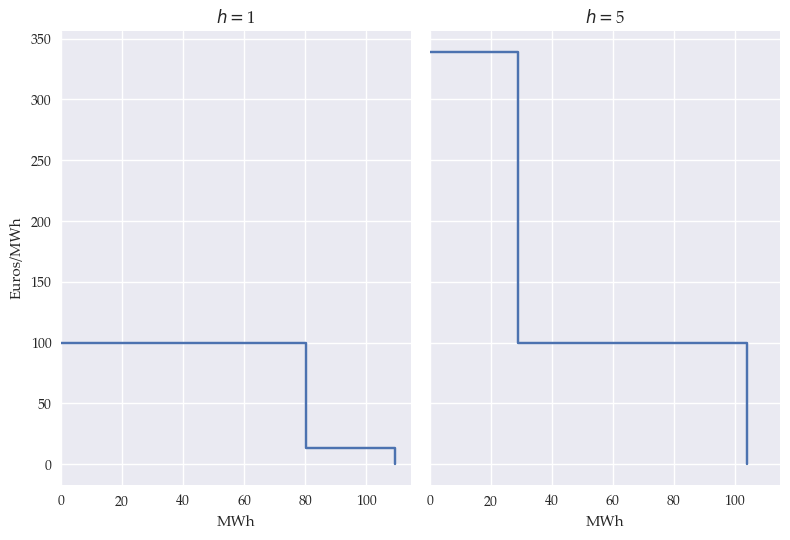

In [13]:
Image(os.path.join(figs_path,'E2.2_sol.png'))

## E3

__Compute and illustrate the hourly supply curve (i.e. the merit order curve) for electricity for hours $h=\{1,5\}$. Include also the demand curve and the optimal value ${\lambda^E_h}^*$.__

*Hint: The figure should look something like this:*

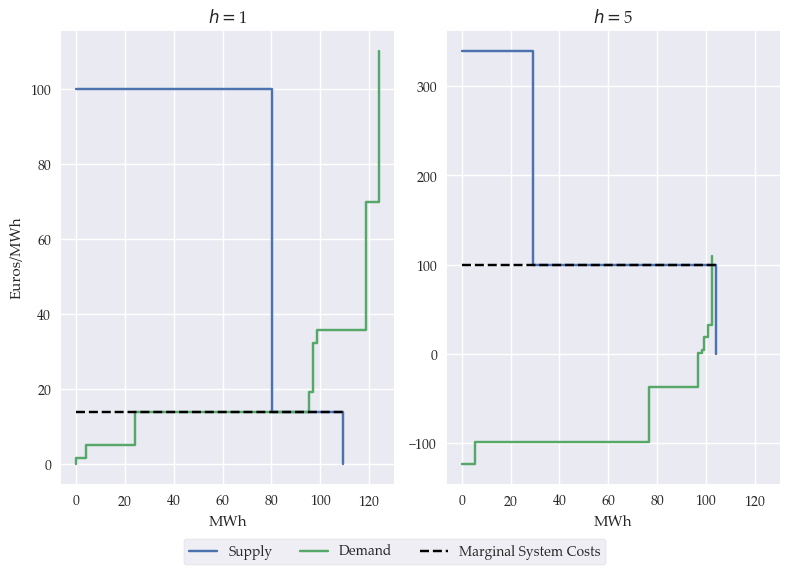

In [14]:
Image(os.path.join(figs_path,'E2.3_sol.png'))

## E4

In this exercise you are asked to simulate the effects of increasing the heat pump capacity. We will do so by solving the model over of an exogenous grid of the heat pump capacity. For making the grid, the `pyDbs` package has a class called `adjMultiIndex`, which has a function called _addGrid_. It takes the four central arguments:

```python
adjMultiIndex.addGrid(v0,vT,index,name)
```
where 
- v0 is a Pandas Index specifying the first element of the grid. 
- vT is a Pandas Index specifying the last element of the grid.
- index is a Pandas Index specifying the number points in the grid.
- name is the name of the variable, we are changing. 

The following makes the grid:

In [15]:
loop = pd.Index(range(11), name = 'l1')
v0 = pd.Series(0.01, index = pd.Index(['g1_HP'], name = 'id'), name = 'GeneratingCap_H')
vT = v0+100
grid = adjMultiIndex.addGrid(v0,vT,index=loop,name='GeneratingCap_H')

__Now use the 'loopSolveExtract'-function in the `modelShell`-class to solve the model of the exogenous grid. Furthermore, extract the following list of variables:__
```python
extract = [
    'meanConsumerPrice_E','meanConsumerPrice_H', # average yearly consumer prices
    'marginalEconomicValue' # marginal economic value of capacity
]
```

## E5

Consider the following figure illustrating the _marginal economic value of generating capacity_ as a function of installed heat pump capacity split into electricity generators $(i\in\mathcal{I}^{E})$, heat generators $(i\in\mathcal{I}^{H})$, and back-pressure plants $(i\in\mathcal{I}^{BP})$:

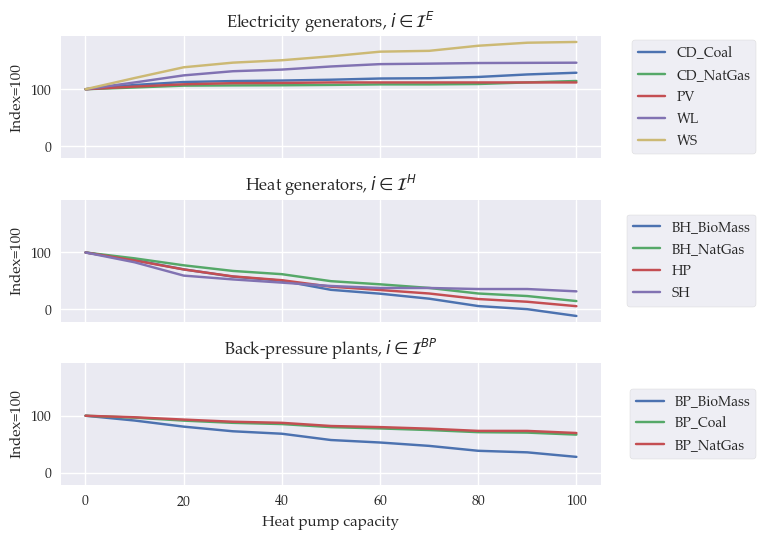

In [16]:
Image(os.path.join(figs_path,'E2.5_sol.png'))

__Define the marginal economic value of capacity and explain the effect of the heat pump capacity on the marginal economic value of generating capacity for (i) electricity producing plants, (ii) heat generating plants, and (iii) back-pressure plants.__

_Hint: The marginal economic value of capacity (MEVoC) is defined by differentiating the Lagrangian function defined in equation (1) of Exercise 41-H with respect to the relevant capacity variable._